In [979]:
import datetime as dt
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat
import plotly.offline as pyo
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from datetime import timedelta
from keras.models import load_model




In [980]:
pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

# Step 1: Specify date range for analysis

In [981]:
end = dt.datetime(2025, 1, 3)
start = dt.datetime(2021, 1 , 1)
start, end

(datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2025, 1, 3, 0, 0))

# Step 2: Select the stocks/tickers

In [982]:
symbol = "NFLX"
df = yf.download(symbol, start=start, end=end).reset_index()
print(df.tail())


C:\Users\Admin\AppData\Local\Temp\ipykernel_24436\1929909933.py:2: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High         Low        Open   Volume
Ticker                   NFLX        NFLX        NFLX        NFLX     NFLX
1001   2024-12-26  924.140015  930.489990  915.299988  928.400024  2340300
1002   2024-12-27  907.549988  918.130005  894.500000  916.010010  3226200
1003   2024-12-30  900.429993  908.229980  889.710022  894.510010  2203000
1004   2024-12-31  891.320007  902.679993  889.469971  901.799988  1875900
1005   2025-01-02  886.729980  898.580017  877.000000  895.500000  2312300


In [983]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        1006 non-null   datetime64[ns]
 1   (Close, NFLX)   1006 non-null   float64       
 2   (High, NFLX)    1006 non-null   float64       
 3   (Low, NFLX)     1006 non-null   float64       
 4   (Open, NFLX)    1006 non-null   float64       
 5   (Volume, NFLX)  1006 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 47.3 KB


In [984]:
df.shape

(1006, 6)

In [959]:
df.describe()

Price,Date,Close,High,Low,Open,Volume
Ticker,,NFLX,NFLX,NFLX,NFLX,NFLX
count,1006,1006.000000,1006.000000,1006.000000,1006.000000,1.006000e+03
mean,2023-01-01 22:19:48.071570688,476.920546,483.377623,470.302843,476.843787,6.185141e+06
min,2021-01-04 00:00:00,166.369995,172.059998,162.710007,163.960007,1.287200e+06
25%,2021-12-31 18:00:00,343.837502,348.272507,337.917511,343.067505,3.010200e+06
50%,2023-01-01 00:00:00,489.104996,494.274994,485.050003,489.839996,4.351500e+06
75%,2024-01-02 18:00:00,605.669998,614.055008,596.479996,604.247498,7.092100e+06
max,2025-01-02 00:00:00,936.559998,941.750000,923.080017,933.349976,1.333875e+08
std,NaN,170.904236,171.801964,169.761035,170.817350,6.779847e+06


# Step 3: Clean and pre-process data:

In [960]:
df.set_index("Date", inplace=True)


In [961]:
df.index = pd.to_datetime(df.index)

In [962]:
df.dropna(inplace=True)

In [963]:
df

Price,Close,High,Low,Open,Volume
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX
Date,,,,,
2021-01-04,522.859985,540.799988,515.090027,539.000000,4444400
2021-01-05,520.799988,526.780029,515.890015,521.549988,3133900
2021-01-06,500.489990,513.099976,499.500000,511.970001,5346200
2021-01-07,508.890015,516.440002,506.420013,508.279999,3686400
2021-01-08,510.399994,513.239990,504.510010,511.309998,2973900
...,...,...,...,...,...
2024-12-26,924.140015,930.489990,915.299988,928.400024,2340300
2024-12-27,907.549988,918.130005,894.500000,916.010010,3226200


# Step 4: Calculate Basic Technical Indicators:

1. Simple Moving Average (SMA) for 20-day and 50-day periods

2. Exponential Moving Average (EMA) for a 20-day period

3. Relative Strength Index (RSI)

# What Is a Simple Moving Average (SMA)?
A simple moving average (SMA) calculates the average price of an asset, usually using closing prices, during a specified period of days.
***
# Formula for SMA (Simple Moving Average)

The SMA at time \( t \) over a period of \( N \) is calculated as follows:

$$
\text{SMA}_t = \frac{P_{t} + P_{t-1} + \cdots + P_{t-(N-1)}}{N}
$$

Where:

- $\text{SMA}_t$: the simple moving average value at time $t$
- $P_t$: the closing price at time $t$
- $N$: the number of periods used to calculate the average (e.g., 5, 10, 20 days)





In [964]:
# Calculate SMA_20
df['SMA_20'] = df['Close'].rolling(window=20,min_periods=0).mean()
df

Price,Close,High,Low,Open,Volume,SMA_20
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX,
Date,,,,,,
2021-01-04,522.859985,540.799988,515.090027,539.000000,4444400,522.859985
2021-01-05,520.799988,526.780029,515.890015,521.549988,3133900,521.829987
2021-01-06,500.489990,513.099976,499.500000,511.970001,5346200,514.716654
2021-01-07,508.890015,516.440002,506.420013,508.279999,3686400,513.259995
2021-01-08,510.399994,513.239990,504.510010,511.309998,2973900,512.687994
...,...,...,...,...,...,...
2024-12-26,924.140015,930.489990,915.299988,928.400024,2340300,912.215497
2024-12-27,907.549988,918.130005,894.500000,916.010010,3226200,913.725995


In [965]:
# Calculate SMA_50
df['SMA_50'] = df['Close'].rolling(window=50,min_periods=0).mean()
df

Price,Close,High,Low,Open,Volume,SMA_20,SMA_50
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX,,
Date,,,,,,,
2021-01-04,522.859985,540.799988,515.090027,539.000000,4444400,522.859985,522.859985
2021-01-05,520.799988,526.780029,515.890015,521.549988,3133900,521.829987,521.829987
2021-01-06,500.489990,513.099976,499.500000,511.970001,5346200,514.716654,514.716654
2021-01-07,508.890015,516.440002,506.420013,508.279999,3686400,513.259995,513.259995
2021-01-08,510.399994,513.239990,504.510010,511.309998,2973900,512.687994,512.687994
...,...,...,...,...,...,...,...
2024-12-26,924.140015,930.489990,915.299988,928.400024,2340300,912.215497,842.212596
2024-12-27,907.549988,918.130005,894.500000,916.010010,3226200,913.725995,846.323596


# What Is an Exponential Moving Average (EMA)?
An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points.The exponential moving average is also referred to as the exponentially weighted moving average. An exponentially weighted moving average reacts more significantly to recent price changes than a simple moving average simple moving average (SMA), which applies an equal weight to all observations in the period.

The formula for calculating the Exponential Moving Average (EMA) at time \( t \) is:

$$
\text{EMA}_t = \alpha \cdot P_t + (1 - \alpha) \cdot \text{EMA}_{t-1}
$$

Where:
- $\text{EMA}_t$: the Exponential Moving Average value at time \( t \)
- $P_t$: the price of the stock (or index) at time \( t \) (e.g., closing price)
- $alpha$: the smoothing factor, calculated using the formula:

$$
\alpha = \frac{2}{N + 1}
$$

Where:
- \( N \): The number of periods (e.g., 12 days, 26 days, etc.)


In [966]:
# Calculate EMA_20
ema_period = 20 
df["EMA_20"] = df["Close"].ewm(span=ema_period, adjust=False).mean()
df.head()

Price,Close,High,Low,Open,Volume,SMA_20,SMA_50,EMA_20
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX,,,
Date,,,,,,,,
2021-01-04,522.859985,540.799988,515.090027,539.000000,4444400,522.859985,522.859985,522.859985
2021-01-05,520.799988,526.780029,515.890015,521.549988,3133900,521.829987,521.829987,522.663795
2021-01-06,500.489990,513.099976,499.500000,511.970001,5346200,514.716654,514.716654,520.552004
2021-01-07,508.890015,516.440002,506.420013,508.279999,3686400,513.259995,513.259995,519.441338
2021-01-08,510.399994,513.239990,504.510010,511.309998,2973900,512.687994,512.687994,518.580258


In [967]:
# Calculate EMA_50
ema_period = 50
df["EMA_50"] = df["Close"].ewm(span=ema_period, adjust=False).mean()
df.head()

Price,Close,High,Low,Open,Volume,SMA_20,SMA_50,EMA_20,EMA_50
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX,,,,
Date,,,,,,,,,
2021-01-04,522.859985,540.799988,515.090027,539.000000,4444400,522.859985,522.859985,522.859985,522.859985
2021-01-05,520.799988,526.780029,515.890015,521.549988,3133900,521.829987,521.829987,522.663795,522.779201
2021-01-06,500.489990,513.099976,499.500000,511.970001,5346200,514.716654,514.716654,520.552004,521.905114
2021-01-07,508.890015,516.440002,506.420013,508.279999,3686400,513.259995,513.259995,519.441338,521.394718
2021-01-08,510.399994,513.239990,504.510010,511.309998,2973900,512.687994,512.687994,518.580258,520.963553


# What Is a Relative Strength Index (RSI)?

The RSI is a momentum oscillator that is widely used in technical analysis of stocks and commodities to identify changes in momentum and price direction.

---

# Relative Strength Index (RSI)

**RSI Formula (period \(N\), usually 14):**

1. **Calculate daily price change:**

$\text{Change}_t = \text{Close}_t - \text{Close}_{t-1}$

2. **Separate gains and losses:**

$\text{Gain}_t = \begin{cases}
\text{Change}_t, & \text{if } \text{Change}_t > 0 \\
0, & \text{otherwise}
\end{cases}$  
$\quad \quad$  
$\text{Loss}_t = \begin{cases}
-\text{Change}_t, & \text{if } \text{Change}_t < 0 \\
0, & \text{otherwise}
\end{cases}$

3. **Calculate the moving averages of Gain and Loss:**

$\text{AvgGain} = \text{MA}(\text{Gain}, N), \quad \text{AvgLoss} = \text{MA}(\text{Loss}, N)$

4. **Calculate RS (Relative Strength):**

$RS = \frac{\text{AvgGain}}{\text{AvgLoss}}$

5. **Calculate RSI:**

$RSI = 100 - \frac{100}{1 + RS}$


In [968]:
# Caculate RSI
def compute_RSI(data, window=14, price_col='Close', ticker=''):
    # Calculate daily price change.
    delta = data[(price_col, ticker)].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the moving averages of Gain and Loss.
    avg_gain = gain.ewm(com=window-1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window-1, min_periods=window).mean()

    # Calculate RS (Relative Strength).
    rs = avg_gain / avg_loss
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi



In [969]:
# Calculate RSI
df['RSI'] = compute_RSI(df, window=14, price_col='Close', ticker=symbol)
df['RSI'] = df['RSI'].fillna(0) #Handling Nan Data
df

Price,Close,High,Low,Open,Volume,SMA_20,SMA_50,EMA_20,EMA_50,RSI
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX,,,,,
Date,,,,,,,,,,
2021-01-04,522.859985,540.799988,515.090027,539.000000,4444400,522.859985,522.859985,522.859985,522.859985,0.000000
2021-01-05,520.799988,526.780029,515.890015,521.549988,3133900,521.829987,521.829987,522.663795,522.779201,0.000000
2021-01-06,500.489990,513.099976,499.500000,511.970001,5346200,514.716654,514.716654,520.552004,521.905114,0.000000
2021-01-07,508.890015,516.440002,506.420013,508.279999,3686400,513.259995,513.259995,519.441338,521.394718,0.000000
2021-01-08,510.399994,513.239990,504.510010,511.309998,2973900,512.687994,512.687994,518.580258,520.963553,0.000000
...,...,...,...,...,...,...,...,...,...,...
2024-12-26,924.140015,930.489990,915.299988,928.400024,2340300,912.215497,842.212596,903.651866,852.233626,61.272228
2024-12-27,907.549988,918.130005,894.500000,916.010010,3226200,913.725995,846.323596,904.023115,854.402895,54.931053


# MACD Indicator
Definition: Moving average convergence/divergence (MACD) is a technical indicator to help investors identify price trends, measure trend momentum, and identify entry points for buying or selling. Moving average convergence/divergence (MACD) is a trend-following momentum indicator that shows the relationship between two exponential moving averages (EMAs) of a security’s price.

Learn more: https://www-investopedia-com.translate.goog/terms/m/macd.asp?_x_tr_sl=en&_x_tr_tl=vi&_x_tr_hl=vi&_x_tr_pto=tc

### 📈 Chỉ số MACD

**1. Calculate MACD:**

$$
\text{MACD}(t) = EMA_{12}(t) - EMA_{26}(t)
$$

**2. Calculate signal line (Signal Line):**

$$
\text{Signal}(t) = EMA_{9}\left( \text{MACD}(t) \right)
$$

**3. Calculate Histogram:**

$$
\text{Histogram}(t) = \text{MACD}(t) - \text{Signal}(t)
$$

---

### Trong đó:

- $ EMA_{12}(t) $: 12-period Exponential Moving Average of the price
- $ EMA_{26}(t) $: 26-period EMA
- $ EMA_{9} $: 9-period EMA of the MACD line (used as the signal line)
- $ t $: Current time or time step (e.g., day)



In [970]:
# Calculate EMA
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()


In [971]:
# Calculate MACD and Signal
macd = ema_12 - ema_26
signal = macd.ewm(span=9, adjust=False).mean()
histogram = macd - signal

In [972]:
# Add to DataFrame adn drop NaN
df['MACD'] = macd
df['Signal'] = signal
df['Histogram'] = histogram
df = df.dropna()

# Step 5: Data analysis:

1. Calculate daily return, return distribution.
2. Calculate volatility (variability) on a monthly or quarterly basis.
3. Analyze the correlation between closing price and SMA, RSI indicators.


# Calculating Daily Return







## 1. Formula for Daily Return per day(Log Return)

# Calculating Daily Return

The formula for **Daily Return** between the closing prices at time \( t \) and \( t-1 \) is:

$$
\text{Log Return} = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Where:
- $ P_t $ is the closing price at time $ t $,
- $ P_{t-1} $ is the closing price at time $ t-1 $,
- $ \ln $ is the natural logarithm (logarithm base $ e $).
\textbf{Total Log Return} được tính bằng công thức:

$
\text{Total Log Return} = \sum_{i=1}^{n} \ln\left(\frac{P_i}{P_{i-1}}\right)
$

Where:
- $ P_i $: The value of the asset at time $ i $,
- $ P_{i-1} $: The value of the asset at time  $i-1 $,
- $ \ln $ is the natural logarithm (logarithm base $ e $).

Alternatively, to calculate the total log return from the first day to the last day:

$
\text{Total Log Return} = \ln\left(\frac{P_t}{P_0}\right)
$

Where:
- $ P_t $: The value of the asset at time $ t $,
- $ P_0 $: The value of the asset at the initial time $ 0 $.


















In [ ]:
# caculate log_return
df['Daily_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Daily_Return'] = df['Daily_Return'].fillna(0) #Handling Nan Data
df.tail()

Price,Close,High,Low,Open,Volume,SMA_20,SMA_50,EMA_20,EMA_50,RSI,MACD,Signal,Histogram,Daily_Return
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX,,,,,,,,,
Date,,,,,,,,,,,,,,
2021-01-04,522.859985,540.799988,515.090027,539.000000,4444400,522.859985,522.859985,522.859985,522.859985,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-05,520.799988,526.780029,515.890015,521.549988,3133900,521.829987,521.829987,522.663795,522.779201,0.000000,-0.164330,-0.032866,-0.131464,-0.003948
2021-01-06,500.489990,513.099976,499.500000,511.970001,5346200,514.716654,514.716654,520.552004,521.905114,0.000000,-1.911377,-0.408568,-1.502809,-0.039778
2021-01-07,508.890015,516.440002,506.420013,508.279999,3686400,513.259995,513.259995,519.441338,521.394718,0.000000,-2.588277,-0.844510,-1.743767,0.016644
2021-01-08,510.399994,513.239990,504.510010,511.309998,2973900,512.687994,512.687994,518.580258,520.963553,0.000000,-2.968661,-1.269340,-1.699321,0.002963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,924.140015,930.489990,915.299988,928.400024,2340300,912.215497,842.212596,903.651866,852.233626,61.272228,20.471057,24.945751,-4.474694,-0.008598
2024-12-27,907.549988,918.130005,894.500000,916.010010,3226200,913.725995,846.323596,904.023115,854.402895,54.931053,18.441440,23.644889,-5.203449,-0.018115


Using formula for total log return over multiple days

In [928]:
print('First', (df['Close'].iloc[0].item()))
print('Last', (df['Close'].iloc[-1].item()))

First 522.8599853515625
Last 886.72998046875


In [929]:
# Caculate total log return
total_daily_return = df['Daily_Return'].iloc[1:].sum()

total_daily_return

np.float64(0.5282268033119553)

In [930]:
# Caculate final log return
last_price_daily_return = df['Close'].iloc[0] * np.exp(total_daily_return)

last_price_daily_return

Ticker
NFLX    886.72998
Name: 2021-01-04 00:00:00, dtype: float64

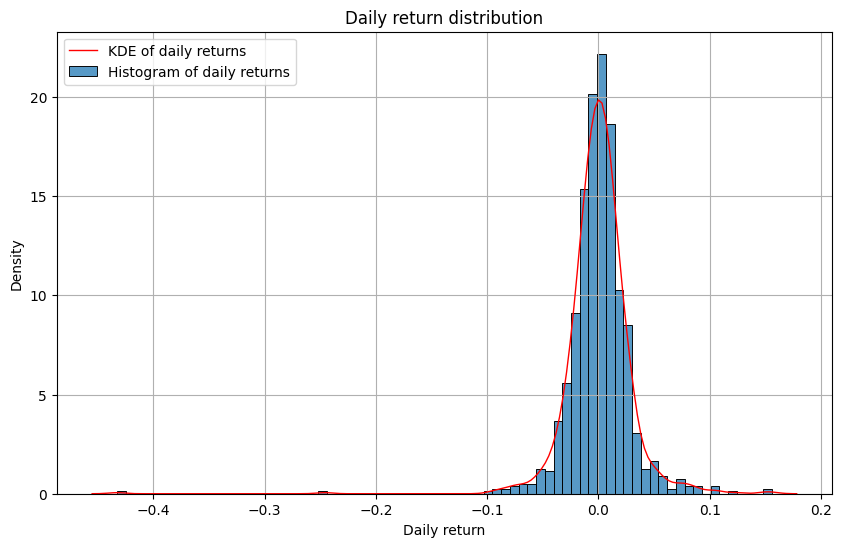

In [931]:
# plot Histogram and KDE of daily return
plt.figure(figsize=(10,6))

sns.histplot(df['Daily_Return'], bins=75, kde=False, stat='density', label='Histogram of daily returns')

sns.kdeplot(df['Daily_Return'], color='red', linewidth=1, label='KDE of daily returns')

plt.title('Daily return distribution')
plt.xlabel('Daily return')
plt.ylabel('Density')
plt.grid(True)

plt.legend()

plt.show()

# 2: Calculate volatility (variability) on a monthly or quarterly basis.

In [932]:
daily_std = df['Daily_Return'].std()
daily_std

np.float64(0.029595403576002856)

In [933]:
# month_volatility 
month_vol = daily_std * np.sqrt(30)
month_vol*100

np.float64(16.210070137045822)

In [934]:
# annualize_volatility
annualize_vol = daily_std * np.sqrt(252)
annualize_vol * 100

np.float64(46.98124668761714)

Trailing volatility over time

In [935]:
# Caculate volatility
TRADING_DAYS = 90
df['Volatility'] = df['Daily_Return'].rolling(window=TRADING_DAYS).std()*np.sqrt(TRADING_DAYS) * 100

In [936]:
volatility = pd.DataFrame(df[ 'Volatility'].dropna())
volatility

,Volatility
Date,
2021-05-12,25.120612
2021-05-13,25.124155
2021-05-14,25.163690
2021-05-17,24.865651
2021-05-18,24.811877
...,...
2024-12-26,17.185796
2024-12-27,17.279956
2024-12-30,17.306707


In [937]:
volatility.plot().update_layout(autosize = False, width=1000, height=400, yaxis_title='Volatility', xaxis=dict(tickformat='%Y', hoverformat='%d-%m-%Y',dtick="M12")).show(renderer="colab") 

# 3: Correlation analysis between closing price and SMA, RSI numbers.

In [734]:
r_closw_sma = np.corrcoef(df[('Close','NFLX')], df['SMA_20'])[0, 1]
print("Correlation Close and SMA_20:", r_closw_sma)

# Close và RSI
r_close_rsi = np.corrcoef(df[('Close','NFLX')], df['RSI'])[0, 1]
print("Correlation Close and RSI:", r_close_rsi)

# SMA_20 và RSI
r_sma_rsi = np.corrcoef(df['SMA_20'], df['RSI'])[0, 1]
print("Correlation SMA_20 and RSI:", r_sma_rsi)


Correlation Close and SMA_20: 0.9843636831651914
Correlation Close and RSI: 0.30551495220934427
Correlation SMA_20 and RSI: 0.16506753869230414


# 6. Visual data:
-  Closing price chart with SMA, EMA.
-  Chart histogram of return.
-  Heatmap matrix compatibility between variables.

1. Closing price chart with SMA, EMA

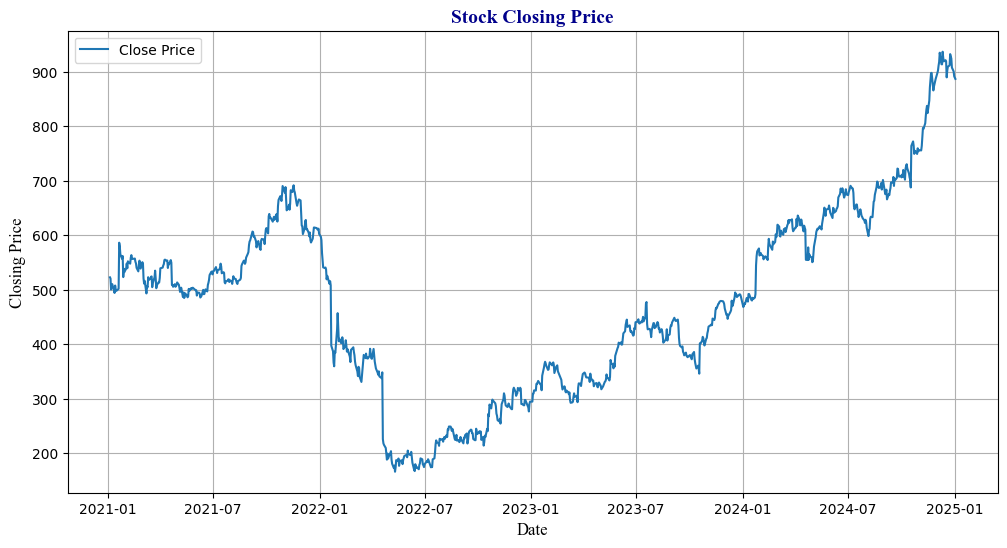

In [735]:
# plot price of Netflix
plt.figure(figsize=(12,6))

sns.lineplot(df['Close'].iloc[:,0], label='Close Price')

plt.title('Stock Closing Price',color='darkblue', fontweight='bold',fontdict={'family': 'Times New Roman', 'size': 14})
plt.xlabel('Date', fontdict={'family': 'Times New Roman', 'size': 12})
plt.ylabel('Closing Price',fontdict={'family': 'Times New Roman', 'size': 12})
plt.legend()
plt.grid(True)
plt.show()

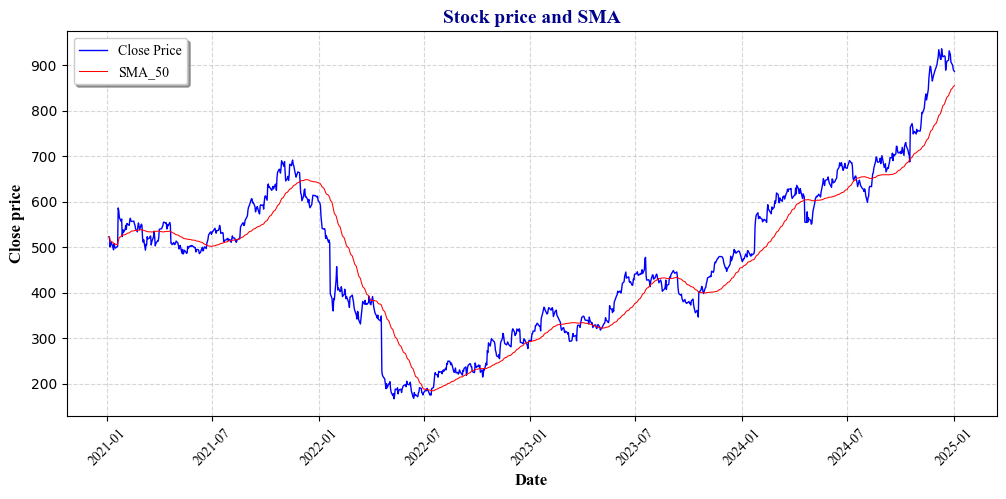

In [736]:
# Price and SMA_50
plt.figure(figsize=(12, 5))

sns.lineplot(df['Close'].iloc[:, 0], label='Close Price', color="blue", linewidth=1)
sns.lineplot(df["SMA_50"], label="SMA_50", color="red", alpha=1, linewidth=0.75)

plt.title("Stock price and SMA", fontsize=14, fontweight='bold', color="darkblue", fontname="Times New Roman")
plt.xlabel("Date", fontsize=12, fontweight='bold', fontname="Times New Roman")
plt.ylabel("Close price", fontsize=12, fontweight='bold', fontname="Times New Roman")

plt.grid(True, linestyle="--", alpha=0.5)

plt.legend(fontsize=10, loc="best", frameon=True, shadow=True, prop={'family': 'Times New Roman'})

plt.xticks(rotation=45, fontsize=10, fontname="Times New Roman")

plt.show()

Envelope SMA

In [737]:
envelope_pct = 0.05
df['Upper_Envelope'] = df['SMA_20'] * (1 + envelope_pct)
df['Lower_Envelope'] = df['SMA_20'] * (1 - envelope_pct)

In [738]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df[('Close', 'NFLX')], mode='lines', name='Close Price'))

fig.add_trace(go.Scatter(x=df.index, y=df['SMA_20'], mode='lines', name='SMA 20'))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Lower_Envelope'],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    hoverinfo='skip',
    name='Lower Envelope'
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Upper_Envelope'],
    mode='lines',
    fill='tonexty',  
    fillcolor='rgba(0, 100, 80, 0.2)', 
    name='Envelope Range',
    line=dict(width=0)
))

fig.update_layout(
    title='Stock Price with Moving Average Envelope (Interactive)',
    xaxis_title='Date',
    yaxis_title='Price',
    hovermode='x unified',
    template='plotly_white',
    font=dict(
            family="Times New Roman",
            size=14,
            color="black"
        )
)
fig.update_xaxes(       
    hoverformat='%d-%m-%Y',
    dtick="M12"          
)
fig.show()

EMA

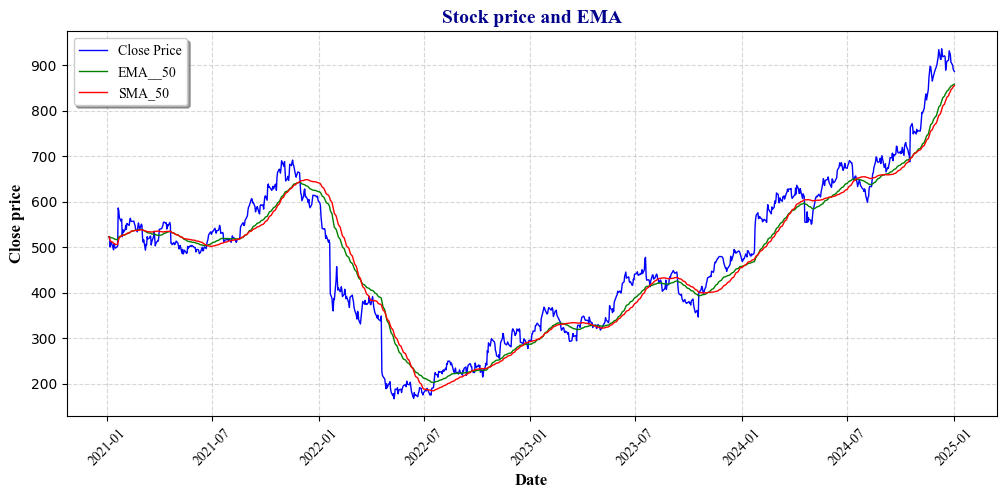

In [739]:
plt.figure(figsize=(12, 5))

sns.lineplot(x=df.index, y=df['Close'].iloc[:, 0], label='Close Price', color="blue", linewidth=1)
sns.lineplot(x=df.index, y=df["EMA_50"], label="EMA__50", color="green", alpha=1, linewidth=1)
sns.lineplot(x=df.index, y=df["SMA_50"], label="SMA_50", color="red", alpha=1, linewidth=1)

plt.title("Stock price and EMA", fontsize=14, fontweight='bold', color="darkblue", fontname="Times New Roman")
plt.xlabel("Date", fontsize=12, fontweight='bold', fontname="Times New Roman")
plt.ylabel("Close price", fontsize=12, fontweight='bold', fontname="Times New Roman")

plt.grid(True, linestyle="--", alpha=0.5)

plt.legend(fontsize=10, loc="best", frameon=True, shadow=True, prop={'family': 'Times New Roman'})

plt.xticks(rotation=45, fontsize=10, fontname="Times New Roman")

plt.show()

In [740]:
# Create a 'YearWeek' column grouping by week
df['YearWeek'] = df.index.to_period('W').start_time

# Group weekly data with allowed features
weekly = df.groupby('YearWeek').agg({
    ('Open', 'NFLX'): 'first',     
    ('High', 'NFLX'): 'max',   
    ('Low', 'NFLX'): 'min',         
    ('Close', 'NFLX'): 'last',     
    ('Volume', 'NFLX'): 'sum'       
}).reset_index()

weekly.rename(columns={'YearWeek': 'Date'}, inplace=True)


In [741]:
#plot Candle sticks
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True,
    vertical_spacing=0.10, subplot_titles=('NFLX', 'Volume'),
    row_width=[0.3, 1]
)

fig.add_trace(
    go.Candlestick(x=weekly['Date'], open=weekly[('Open', 'NFLX')],
        high=weekly[('High', 'NFLX')], low=weekly[('Low', 'NFLX')],
        close=weekly[('Close', 'NFLX')], name='OHLC'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=weekly['Date'],
        y=weekly[('Volume', 'NFLX')],
        marker=dict(color='#FF0000', opacity=1),
        showlegend=False
    ),
    row=2, col=1
)

fig.update_layout(
    title='NFLX Price Chart',

    xaxis=dict(
        tickfont=dict(size=12)
    ),

    yaxis=dict(
        title=dict(
            text='Price ($/share)',
            font=dict(size=14)
        ),
        tickfont=dict(size=12)
    ),

    autosize=True,
    width=900,
    height=600,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor='white',

    font=dict(
        family="Times New Roman", 
        size=14,  
        color="darkblue",
        weight='bold'  
    )
)

fig.update_xaxes(
    tickformat='%d-%m-%Y', 
    hoverformat='%d-%m-%Y'
)

fig.update_xaxes(visible=False, row=2, col=1)
fig.update(layout_xaxis_rangeslider_visible=False)

fig.show()


In [742]:
# plot RSI and Price of stock
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    row_heights=[0.7, 0.3],
                    vertical_spacing=0.05,
                    subplot_titles=("Stock Price with Envelope", "RSI (14-day)"))


fig.add_trace(go.Scatter(x=df.index, y=df[('Close', 'NFLX')], name='Close Price'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['SMA_20'], name='SMA 20'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['Lower_Envelope'], line=dict(width=0),name='Envelope Lower', showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['Upper_Envelope'],fill='tonexty', fillcolor='rgba(0, 100, 80, 0.2)',name='Envelope Uper', line=dict(dash='dot', color='rgba(0,100,80,0.5)')
), row=1, col=1)

# RSI 
fig.add_trace(go.Scatter(x=df.index, y=df['RSI'], name='RSI', line=dict(color='orange')), row=2, col=1)

# add path 70 và 30
fig.add_shape(type='line', x0=df.index.min(), x1=df.index.max(), y0=70, y1=70,
              line=dict(color='red', dash='dash'), row=2, col=1)
fig.add_shape(type='line', x0=df.index.min(), x1=df.index.max(), y0=30, y1=30,
              line=dict(color='green', dash='dash'), row=2, col=1)

fig.update_layout(
    title='Stock Price and RSI (Interactive)',
    height=700,
    template='plotly_white',
    font=dict(family='Times New Roman',color='darkblue', size=14),
    hovermode='x unified'
    
)
# Add annotation
fig.add_annotation(
    x=df.index.max(), y=70,
    xref='x2', yref='y2',  
    text='70 (Overbought)',
    showarrow=False,
    font=dict(color='red', size=12),
    xanchor='left',
    yanchor='bottom'
)

fig.add_annotation(
    x=df.index.max(), y=30,
    xref='x2', yref='y2',
    text='30 (Oversold)',
    showarrow=False,
    font=dict(color='green', size=12),
    xanchor='left',
    yanchor='top'
)

fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="RSI", range=[0, 100], row=2, col=1)
fig.update_xaxes(       
    hoverformat='%d-%m-%Y',
    dtick="M12"          
)

fig.show()

In [743]:
# MACD and Price Stock
colors = ['green' if val >= 0 else 'red' for val in df['Histogram']]

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True,
    vertical_spacing=0.1, subplot_titles=('NFLX Price', 'MACD Indicator'),
    row_width=[0.3, 0.7]
)

fig.add_trace(go.Scatter(x=df.index, y=df[('Close', 'NFLX')], name='Close Price',  line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['Signal'], name='Signal',line=dict(color='red')), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], name='MACD',line=dict(color='green')), row=2, col=1)
fig.add_trace(go.Bar(x=df.index, y=df['Histogram'],marker_color=colors,name='Histogram'), row=2, col=1)
fig.update_layout(
    title='Stock Price and MACD Indicator',
    height=700,
    template='plotly_white',
    font=dict(family='Times New Roman',color='darkblue', size=14),
    hovermode='x unified'
    
)
fig.update_xaxes(       
    hoverformat='%d-%m-%Y',
    dtick="M12"          
)
fig.show()

# Compare with stocks of companies in the same industry (NFLX, DIS, LYV, TKO, FOX )

In [744]:
# Selecting multiple stocks
stock_List = ['NFLX', 'DIS', 'LYV', 'TKO', 'FOX'] 

In [745]:
# Download data
df_Stock = yf.download(stock_List, start=start, end=end).reset_index()
print(df.tail())

C:\Users\Admin\AppData\Local\Temp\ipykernel_24436\821978368.py:2: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  5 of 5 completed

Price            Close        High         Low        Open   Volume  \
Ticker            NFLX        NFLX        NFLX        NFLX     NFLX   
Date                                                                  
2024-12-26  924.140015  930.489990  915.299988  928.400024  2340300   
2024-12-27  907.549988  918.130005  894.500000  916.010010  3226200   
2024-12-30  900.429993  908.229980  889.710022  894.510010  2203000   
2024-12-31  891.320007  902.679993  889.469971  901.799988  1875900   
2025-01-02  886.729980  898.580017  877.000000  895.500000  2312300   

Price           SMA_20      SMA_50      EMA_20      EMA_50        RSI  \
Ticker                                                                  
Date                                                                    
2024-12-26  912.215497  842.212596  903.651866  852.233626  61.272228   
2024-12-27  913.725995  846.323596  904.023115  854.402895  54.931053   
2024-12-30  914.406995  850.579196  903.680913  856.207879  52.423

In [746]:
df_Stock.set_index("Date", inplace=True)

In [747]:
# calculate SMA_20, RSI, Simple Return, Log Return, Volatility
stock_List = ['NFLX', 'DIS', 'LYV', 'TKO', 'FOX'] 
for ticker in stock_List:
    df_Stock[('SMA_20', ticker)] = df_Stock[('Close', ticker)].rolling(window=20, min_periods=0).mean()
for ticker in stock_List:
    df_Stock[('RSI_Close', ticker)] = compute_RSI(df_Stock, window=14, price_col='Close', ticker=ticker).fillna(0)
for ticker in stock_List:
    df_Stock[('Simple_Return', ticker)] = df_Stock[('Close', ticker)].pct_change()
for ticker in stock_List:
    df_Stock[('Log_Return', ticker)] = np.log(df_Stock[('Close', ticker)] / df_Stock[('Close', ticker)].shift(1))
for ticker in stock_List:
    df_Stock[('Volatility', ticker)] = df_Stock[('Log_Return', ticker)].rolling(window=TRADING_DAYS).std() * np.sqrt(TRADING_DAYS) * 100
df_Stock = df_Stock.dropna()
df_Stock

Price            Close                                                 \
Ticker             DIS        FOX         LYV        NFLX         TKO   
Date                                                                    
2021-05-13  176.163727  34.927113   81.230003  486.660004   49.769817   
2021-05-14  171.580353  34.173355   85.800003  493.369995   50.599152   
2021-05-17  168.004532  33.768215   84.519997  488.940002   50.797066   
2021-05-18  167.609406  34.220467   87.089996  486.279999   49.920609   
2021-05-19  167.204422  34.126247   87.300003  487.700012   49.656727   
...                ...        ...         ...         ...         ...   
2024-12-26  112.550003  46.679199  133.350006  924.140015  144.014893   
2024-12-27  111.550003  46.390694  131.850006  907.549988  143.298508   
2024-12-30  110.800003  45.843517  131.009995  900.429993  142.651764   
2024-12-31  111.349998  45.505260  129.500000  891.320007  141.398071   
2025-01-02  110.820000  46.002693  129.229996  886.729980  142.014969   

Price             High                                                 ...  \
Ticker             DIS        FOX         LYV        NFLX         TKO  ...   
Date                                                                   ...   
2021-05-13  178.544321  35.341676   81.550003  490.779999   50.712249  ...   
2021-05-14  172.775594  34.960086   85.870003  494.850006   50.712246  ...   
2021-05-17  170.879025  34.955377   86.500000  492.709991   51.249432  ...   
2021-05-18  169.170127  34.672719   88.779999  493.480011   50.825342  ...   
2021-05-19  167.332825  34.324107   87.389999  488.570007   49.948882  ...   
...                ...        ...         ...         ...         ...  ...   
2024-12-26  113.320000  46.987610  133.690002  930.489990  144.144231  ...   
2024-12-27  112.120003  46.709051  133.169998  918.130005  143.567144  ...   
2024-12-30  111.540001  46.206642  132.139999  908.229980  143.686562  ...   
2024-12-31  111.589996  46.042486  131.779999  902.679993  143.298506  ...   
2025-01-02  112.199997  46.161872  130.600006  898.580017  143.119409  ...   

Price      Log_Return                                         Volatility  \
Ticker           NFLX       DIS       LYV       TKO       FOX       NFLX   
Date                                                                       
2021-05-13   0.003458  0.002751  0.041730  0.000000  0.015770  25.124155   
2021-05-14   0.013694 -0.026362  0.054734  0.016526 -0.021817  25.163690   
2021-05-17  -0.009020 -0.021061 -0.015031  0.003904 -0.011926  24.865651   
2021-05-18  -0.005455 -0.002355  0.029954 -0.017405  0.013304  24.811877   
2021-05-19   0.002916 -0.002419  0.002408 -0.005300 -0.002757  24.811811   
...               ...       ...       ...       ...       ...        ...   
2024-12-26  -0.008598 -0.000089  0.000225 -0.000829 -0.004890  17.185796   
2024-12-27  -0.018115 -0.008925 -0.011312 -0.004987 -0.006200  17.279956   
2024-12-30  -0.007876 -0.006746 -0.006391 -0.004523 -0.011865  17.306707   
2024-12-31  -0.010169  0.004952 -0.011593 -0.008827 -0.007406  17.293734   
2025-01-02  -0.005163 -0.004771 -0.002087  0.004353  0.010872  17.301655   

Price                                                   
Ticker            DIS        LYV        TKO        FOX  
Date                                                    
2021-05-13  16.462379  23.559920  23.369963  26.874631  
2021-05-14  16.666539  24.095098  23.368139  26.925495  
2021-05-17  16.789661  24.145031  23.353241  25.768942  
2021-05-18  16.788814  24.307587  23.425913  25.451897  
2021-05-19  16.789393  24.303953  23.429238  25.355255  
...               ...        ...        ...        ...  
2024-12-26  12.394328  13.661233  17.220950  11.704274  
2024-12-27  12.362326  13.742268  17.227832  11.729106  
2024-12-30  12.366805  13.758338  17.231494  11.784511  
2024-12-31  12.318150  13.812857  17.159519  11.801774  
2025-01-02  12.329809  13.813329  17.161005  11.829285  

[916 rows x 50 colum

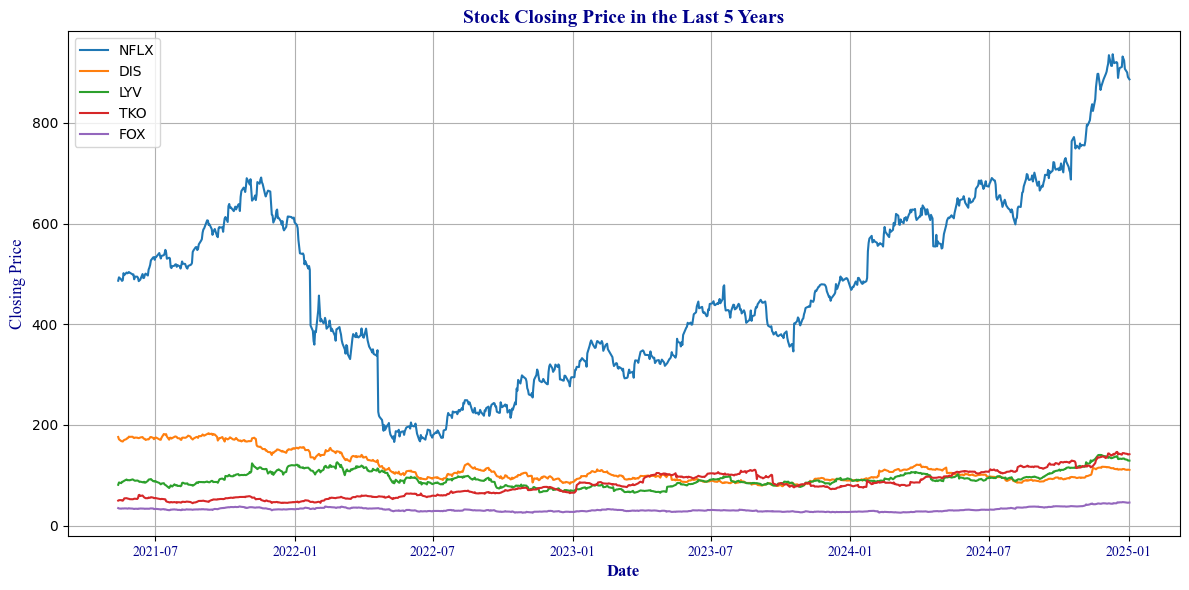

In [748]:
# plotting the closing price of selected stocks
plt.figure(figsize=(12,6))

for ticker in stock_List:
    sns.lineplot(x=df_Stock.index, y=df_Stock[('Close', ticker)], label=ticker)

plt.title('Stock Closing Price in the Last 5 Years', fontsize=14, fontweight='bold', fontname="Times New Roman", color="darkblue")
plt.xlabel('Date', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontname': 'Times New Roman', 'color': 'darkblue'})
plt.xticks(fontsize=10, fontname="Times New Roman",color="darkblue")
plt.ylabel('Closing Price', fontsize=12, fontname="Times New Roman",color ="darkblue")
plt.legend(title='Stocks', fontsize=10, title_fontsize='12', loc='upper left', frameon=True, shadow=True, prop={'family': 'Times New Roman'})
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


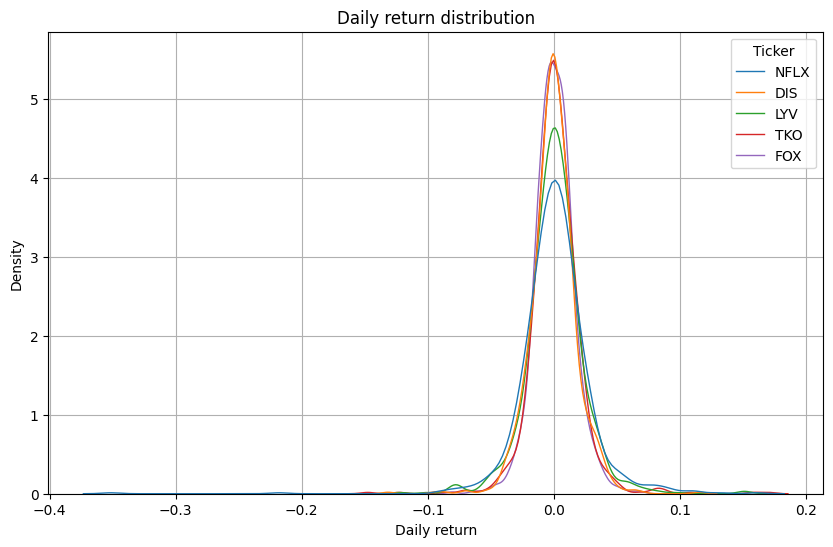

In [749]:
# compare growth rate with Daily return.
plt.figure(figsize=(10,6))
sns.kdeplot(df_Stock['Simple_Return'], color='red', linewidth=1)
plt.title('Daily return distribution')
plt.xlabel('Daily return')
plt.ylabel('Density')
plt.grid(True)
plt.show()


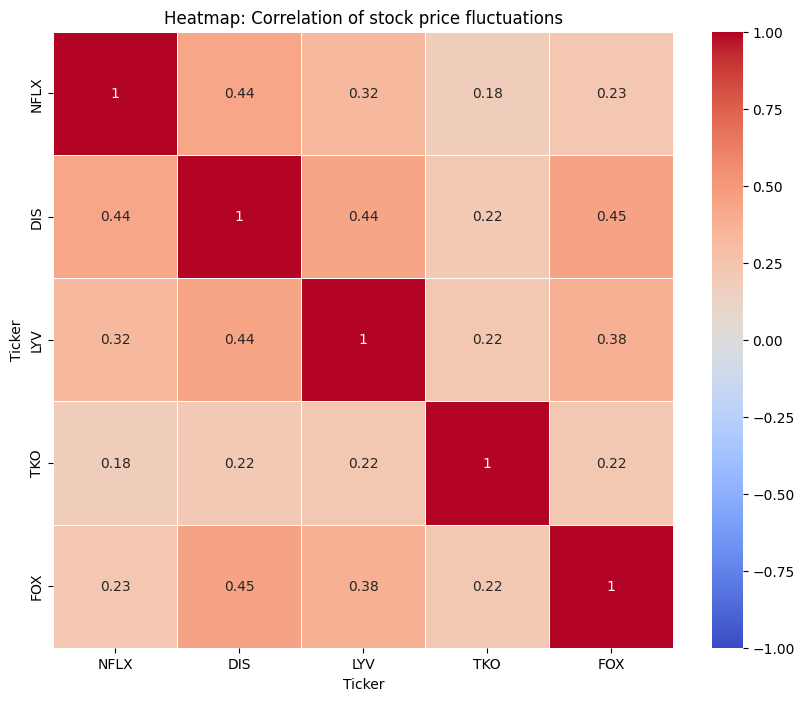

In [750]:
# Heatmap Correlation of stock price fluctuations
correlation_matrix = df_Stock['Log_Return'].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Heatmap: Correlation of stock price fluctuations')
plt.show()


Build Model AI

In [751]:
# Create a new dataframe with only the 'Close' column
data = df.filter([('Close','NFLX')])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

805

In [752]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data


array([[0.4628598 ],
       [0.46018514],
       [0.43381502],
       ...,
       [0.95308949],
       [0.94126126],
       [0.93530166]])

In [753]:
# Create the training dataset
train_data = scaled_data[0:int(training_data_len), :]
# Create the x_train and y_train datasets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.4628598 , 0.46018514, 0.43381502, 0.44472146, 0.44668198,
       0.4320103 , 0.42571314, 0.44329323, 0.43429542, 0.43055612,
       0.43547695, 0.54528107, 0.5368416 , 0.51779429, 0.50690094,
       0.51358755, 0.46340518, 0.4832963 , 0.47523341, 0.48386759,
       0.49570882, 0.48439997, 0.50090234, 0.49912357, 0.49539722,
       0.5098742 , 0.51574291, 0.50795262, 0.50656335, 0.50755013,
       0.49983774, 0.49578672, 0.48539967, 0.47703818, 0.49309914,
       0.50252532, 0.49381324, 0.4836209 , 0.49892886, 0.49526742,
       0.46005533, 0.44783756, 0.45445931, 0.42451861, 0.44154041,
       0.43907349, 0.46311949, 0.45657568, 0.45947104, 0.46437896,
       0.46491126, 0.43939809, 0.4489931 , 0.46318439, 0.47873905,
       0.46019813, 0.43689218, 0.44363078, 0.45129126, 0.45056417])]
[np.float64(0.4613017267182368)]

[array([0.4628598 , 0.46018514, 0.43381502, 0.44472146, 0.44668198,
       0.4320103 , 0.42571314, 0.44329323, 0.43429542, 0.43055612,
       0.43547695, 0.545

In [754]:
np.shape(x_train), np.shape(y_train)

((745, 60), (745,))

In [755]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(745, 60, 1)

In [756]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


c:\Users\Admin\Project\tfenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [757]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [758]:
from keras.callbacks import ModelCheckpoint

In [759]:
#Train the model
saved_model = 'saved_model.h5'
best_model = ModelCheckpoint(saved_model, monitor='loss', save_best_only=True, mode='auto', verbose=2)
model.fit(x_train, y_train, batch_size=32 , epochs=100, callbacks=[best_model],verbose=2)


Epoch 1/100

Epoch 1: loss improved from inf to 0.01679, saving model to saved_model.h5


24/24 - 2s - 65ms/step - loss: 0.0168
Epoch 2/100

Epoch 2: loss improved from 0.01679 to 0.00214, saving model to saved_model.h5


24/24 - 0s - 15ms/step - loss: 0.0021
Epoch 3/100

Epoch 3: loss improved from 0.00214 to 0.00136, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 0.0014
Epoch 4/100

Epoch 4: loss improved from 0.00136 to 0.00126, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 0.0013
Epoch 5/100

Epoch 5: loss improved from 0.00126 to 0.00117, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 0.0012
Epoch 6/100

Epoch 6: loss improved from 0.00117 to 0.00112, saving model to saved_model.h5


24/24 - 0s - 13ms/step - loss: 0.0011
Epoch 7/100

Epoch 7: loss improved from 0.00112 to 0.00106, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 0.0011
Epoch 8/100

Epoch 8: loss did not improve from 0.00106
24/24 - 0s - 13ms/step - loss: 0.0011
Epoch 9/100

Epoch 9: loss improved from 0.00106 to 0.00094, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 9.3833e-04
Epoch 10/100

Epoch 10: loss improved from 0.00094 to 0.00090, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 8.9999e-04
Epoch 11/100

Epoch 11: loss improved from 0.00090 to 0.00084, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 8.4455e-04
Epoch 12/100

Epoch 12: loss did not improve from 0.00084
24/24 - 0s - 13ms/step - loss: 8.8407e-04
Epoch 13/100

Epoch 13: loss did not improve from 0.00084
24/24 - 0s - 13ms/step - loss: 0.0010
Epoch 14/100

Epoch 14: loss improved from 0.00084 to 0.00077, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 7.6973e-04
Epoch 15/100

Epoch 15: loss improved from 0.00077 to 0.00075, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 7.5354e-04
Epoch 16/100

Epoch 16: loss did not improve from 0.00075
24/24 - 0s - 13ms/step - loss: 7.7598e-04
Epoch 17/100

Epoch 17: loss improved from 0.00075 to 0.00071, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 7.1180e-04
Epoch 18/100

Epoch 18: loss did not improve from 0.00071
24/24 - 0s - 13ms/step - loss: 7.5314e-04
Epoch 19/100

Epoch 19: loss improved from 0.00071 to 0.00070, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 6.9983e-04
Epoch 20/100

Epoch 20: loss did not improve from 0.00070
24/24 - 0s - 13ms/step - loss: 7.5287e-04
Epoch 21/100

Epoch 21: loss did not improve from 0.00070
24/24 - 0s - 13ms/step - loss: 8.7177e-04
Epoch 22/100

Epoch 22: loss improved from 0.00070 to 0.00069, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 6.8529e-04
Epoch 23/100

Epoch 23: loss did not improve from 0.00069
24/24 - 0s - 13ms/step - loss: 6.9215e-04
Epoch 24/100

Epoch 24: loss improved from 0.00069 to 0.00062, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 6.2108e-04
Epoch 25/100

Epoch 25: loss improved from 0.00062 to 0.00061, saving model to saved_model.h5


24/24 - 0s - 15ms/step - loss: 6.0965e-04
Epoch 26/100

Epoch 26: loss did not improve from 0.00061
24/24 - 0s - 13ms/step - loss: 6.8064e-04
Epoch 27/100

Epoch 27: loss did not improve from 0.00061
24/24 - 0s - 13ms/step - loss: 6.1731e-04
Epoch 28/100

Epoch 28: loss improved from 0.00061 to 0.00057, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 5.7013e-04
Epoch 29/100

Epoch 29: loss did not improve from 0.00057
24/24 - 0s - 12ms/step - loss: 6.2225e-04
Epoch 30/100

Epoch 30: loss did not improve from 0.00057
24/24 - 0s - 13ms/step - loss: 5.9524e-04
Epoch 31/100

Epoch 31: loss improved from 0.00057 to 0.00054, saving model to saved_model.h5


24/24 - 0s - 13ms/step - loss: 5.4403e-04
Epoch 32/100

Epoch 32: loss improved from 0.00054 to 0.00053, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 5.3411e-04
Epoch 33/100

Epoch 33: loss did not improve from 0.00053
24/24 - 0s - 12ms/step - loss: 5.8228e-04
Epoch 34/100

Epoch 34: loss did not improve from 0.00053
24/24 - 0s - 13ms/step - loss: 6.2003e-04
Epoch 35/100

Epoch 35: loss improved from 0.00053 to 0.00051, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 5.0597e-04
Epoch 36/100

Epoch 36: loss did not improve from 0.00051
24/24 - 0s - 13ms/step - loss: 5.0962e-04
Epoch 37/100

Epoch 37: loss did not improve from 0.00051
24/24 - 0s - 13ms/step - loss: 5.2975e-04
Epoch 38/100

Epoch 38: loss did not improve from 0.00051
24/24 - 0s - 12ms/step - loss: 5.3539e-04
Epoch 39/100

Epoch 39: loss did not improve from 0.00051
24/24 - 0s - 13ms/step - loss: 5.1773e-04
Epoch 40/100

Epoch 40: loss improved from 0.00051 to 0.00049, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 4.8683e-04
Epoch 41/100

Epoch 41: loss improved from 0.00049 to 0.00048, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 4.8263e-04
Epoch 42/100

Epoch 42: loss improved from 0.00048 to 0.00048, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 4.8072e-04
Epoch 43/100

Epoch 43: loss did not improve from 0.00048
24/24 - 0s - 13ms/step - loss: 5.1690e-04
Epoch 44/100

Epoch 44: loss did not improve from 0.00048
24/24 - 0s - 13ms/step - loss: 4.8718e-04
Epoch 45/100

Epoch 45: loss improved from 0.00048 to 0.00045, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 4.5115e-04
Epoch 46/100

Epoch 46: loss improved from 0.00045 to 0.00043, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 4.3175e-04
Epoch 47/100

Epoch 47: loss did not improve from 0.00043
24/24 - 0s - 13ms/step - loss: 4.3419e-04
Epoch 48/100

Epoch 48: loss did not improve from 0.00043
24/24 - 0s - 13ms/step - loss: 4.5586e-04
Epoch 49/100

Epoch 49: loss did not improve from 0.00043
24/24 - 0s - 13ms/step - loss: 4.4478e-04
Epoch 50/100

Epoch 50: loss did not improve from 0.00043
24/24 - 0s - 13ms/step - loss: 4.8047e-04
Epoch 51/100

Epoch 51: loss did not improve from 0.00043
24/24 - 0s - 12ms/step - loss: 4.4550e-04
Epoch 52/100

Epoch 52: loss improved from 0.00043 to 0.00041, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 4.1266e-04
Epoch 53/100

Epoch 53: loss improved from 0.00041 to 0.00040, saving model to saved_model.h5


24/24 - 0s - 13ms/step - loss: 4.0158e-04
Epoch 54/100

Epoch 54: loss did not improve from 0.00040
24/24 - 0s - 13ms/step - loss: 4.1709e-04
Epoch 55/100

Epoch 55: loss improved from 0.00040 to 0.00038, saving model to saved_model.h5


24/24 - 0s - 13ms/step - loss: 3.7775e-04
Epoch 56/100

Epoch 56: loss did not improve from 0.00038
24/24 - 0s - 13ms/step - loss: 4.0623e-04
Epoch 57/100

Epoch 57: loss did not improve from 0.00038
24/24 - 0s - 12ms/step - loss: 4.0536e-04
Epoch 58/100

Epoch 58: loss did not improve from 0.00038
24/24 - 0s - 12ms/step - loss: 4.1239e-04
Epoch 59/100

Epoch 59: loss did not improve from 0.00038
24/24 - 0s - 13ms/step - loss: 3.9232e-04
Epoch 60/100

Epoch 60: loss did not improve from 0.00038
24/24 - 0s - 12ms/step - loss: 4.1337e-04
Epoch 61/100

Epoch 61: loss improved from 0.00038 to 0.00037, saving model to saved_model.h5


24/24 - 0s - 13ms/step - loss: 3.7225e-04
Epoch 62/100

Epoch 62: loss improved from 0.00037 to 0.00037, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 3.6725e-04
Epoch 63/100

Epoch 63: loss improved from 0.00037 to 0.00036, saving model to saved_model.h5


24/24 - 0s - 13ms/step - loss: 3.5860e-04
Epoch 64/100

Epoch 64: loss improved from 0.00036 to 0.00033, saving model to saved_model.h5


24/24 - 0s - 13ms/step - loss: 3.2542e-04
Epoch 65/100

Epoch 65: loss did not improve from 0.00033
24/24 - 0s - 13ms/step - loss: 3.5024e-04
Epoch 66/100

Epoch 66: loss did not improve from 0.00033
24/24 - 0s - 12ms/step - loss: 3.5000e-04
Epoch 67/100

Epoch 67: loss improved from 0.00033 to 0.00031, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 3.0830e-04
Epoch 68/100

Epoch 68: loss improved from 0.00031 to 0.00030, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 2.9836e-04
Epoch 69/100

Epoch 69: loss did not improve from 0.00030
24/24 - 0s - 13ms/step - loss: 3.2010e-04
Epoch 70/100

Epoch 70: loss did not improve from 0.00030
24/24 - 0s - 13ms/step - loss: 3.1739e-04
Epoch 71/100

Epoch 71: loss did not improve from 0.00030
24/24 - 0s - 12ms/step - loss: 3.3344e-04
Epoch 72/100

Epoch 72: loss did not improve from 0.00030
24/24 - 0s - 13ms/step - loss: 3.1006e-04
Epoch 73/100

Epoch 73: loss did not improve from 0.00030
24/24 - 0s - 13ms/step - loss: 3.3938e-04
Epoch 74/100

Epoch 74: loss improved from 0.00030 to 0.00030, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 2.9666e-04
Epoch 75/100

Epoch 75: loss improved from 0.00030 to 0.00029, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 2.8542e-04
Epoch 76/100

Epoch 76: loss did not improve from 0.00029
24/24 - 0s - 13ms/step - loss: 3.3215e-04
Epoch 77/100

Epoch 77: loss did not improve from 0.00029
24/24 - 0s - 12ms/step - loss: 3.3155e-04
Epoch 78/100

Epoch 78: loss did not improve from 0.00029
24/24 - 0s - 13ms/step - loss: 2.8770e-04
Epoch 79/100

Epoch 79: loss improved from 0.00029 to 0.00026, saving model to saved_model.h5


24/24 - 0s - 13ms/step - loss: 2.6248e-04
Epoch 80/100

Epoch 80: loss improved from 0.00026 to 0.00026, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 2.6032e-04
Epoch 81/100

Epoch 81: loss did not improve from 0.00026
24/24 - 0s - 13ms/step - loss: 3.1348e-04
Epoch 82/100

Epoch 82: loss did not improve from 0.00026
24/24 - 0s - 13ms/step - loss: 3.3264e-04
Epoch 83/100

Epoch 83: loss did not improve from 0.00026
24/24 - 0s - 13ms/step - loss: 2.6537e-04
Epoch 84/100

Epoch 84: loss improved from 0.00026 to 0.00025, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 2.4788e-04
Epoch 85/100

Epoch 85: loss did not improve from 0.00025
24/24 - 0s - 12ms/step - loss: 2.7055e-04
Epoch 86/100

Epoch 86: loss did not improve from 0.00025
24/24 - 0s - 13ms/step - loss: 2.4829e-04
Epoch 87/100

Epoch 87: loss did not improve from 0.00025
24/24 - 0s - 13ms/step - loss: 2.7628e-04
Epoch 88/100

Epoch 88: loss improved from 0.00025 to 0.00025, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 2.4774e-04
Epoch 89/100

Epoch 89: loss did not improve from 0.00025
24/24 - 0s - 13ms/step - loss: 3.1879e-04
Epoch 90/100

Epoch 90: loss did not improve from 0.00025
24/24 - 0s - 13ms/step - loss: 3.1867e-04
Epoch 91/100

Epoch 91: loss did not improve from 0.00025
24/24 - 0s - 12ms/step - loss: 2.6949e-04
Epoch 92/100

Epoch 92: loss did not improve from 0.00025
24/24 - 0s - 13ms/step - loss: 2.9436e-04
Epoch 93/100

Epoch 93: loss did not improve from 0.00025
24/24 - 0s - 13ms/step - loss: 2.6973e-04
Epoch 94/100

Epoch 94: loss did not improve from 0.00025
24/24 - 0s - 12ms/step - loss: 2.7552e-04
Epoch 95/100

Epoch 95: loss did not improve from 0.00025
24/24 - 0s - 13ms/step - loss: 2.9219e-04
Epoch 96/100

Epoch 96: loss improved from 0.00025 to 0.00025, saving model to saved_model.h5


24/24 - 0s - 13ms/step - loss: 2.4507e-04
Epoch 97/100

Epoch 97: loss improved from 0.00025 to 0.00024, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 2.4158e-04
Epoch 98/100

Epoch 98: loss did not improve from 0.00024
24/24 - 0s - 12ms/step - loss: 2.4598e-04
Epoch 99/100

Epoch 99: loss improved from 0.00024 to 0.00024, saving model to saved_model.h5


24/24 - 0s - 14ms/step - loss: 2.3777e-04
Epoch 100/100

Epoch 100: loss did not improve from 0.00024
24/24 - 0s - 13ms/step - loss: 2.4462e-04


In [760]:
final_model = load_model('saved_model.h5')

In [761]:
#Crteate the testing dataset
#Create a new aray containing scaled values
test_data = scaled_data[training_data_len - 60:, :]
# Create the x_test dataset
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    


In [762]:
# Convert the data to a numpy array
x_test = np.array(x_test)


In [763]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [764]:
#Get the models predicted price values
predictions = final_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [765]:
# Got the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
rmse

np.float64(12.888869951605932)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24436\3443820383.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



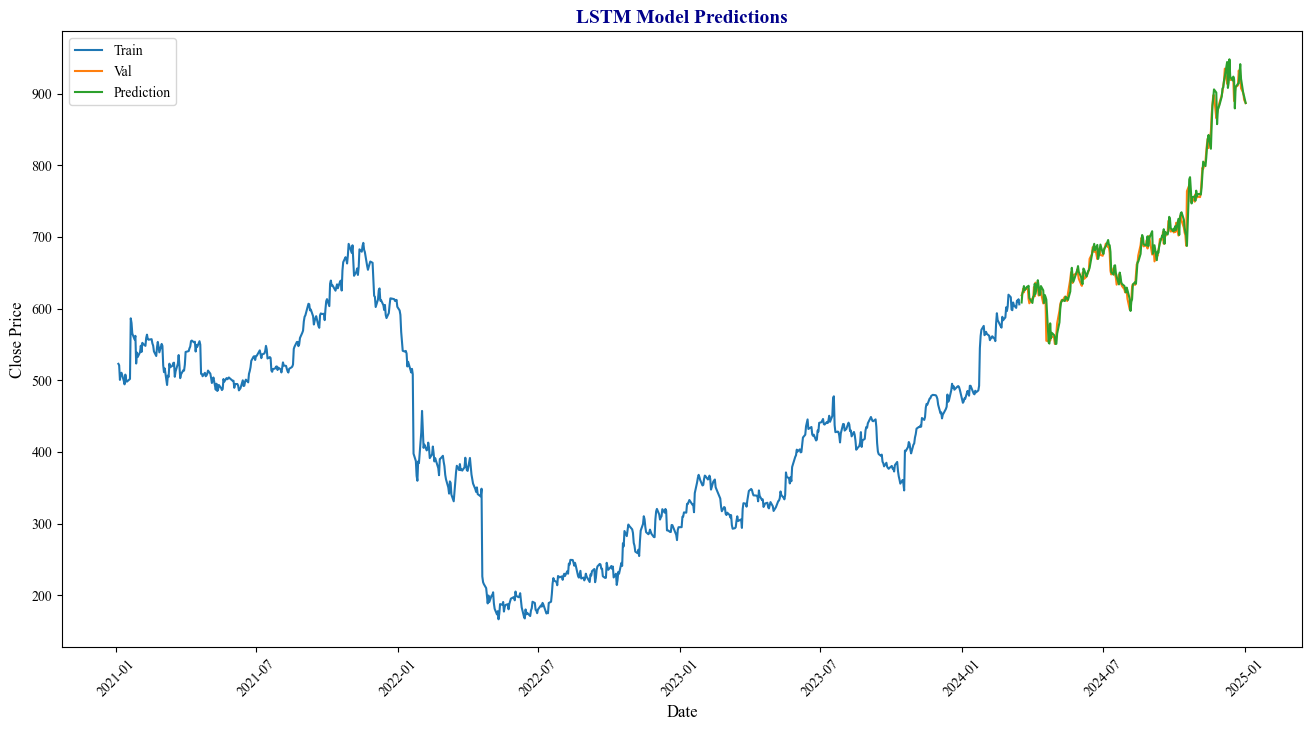

In [766]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Val')
plt.plot(valid['Predictions'], label='Prediction')
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.xticks(rotation=45, fontsize=10, fontname="Times New Roman")
plt.xlabel('Date', fontsize=12, fontname="Times New Roman")
plt.yticks(fontsize=10, fontname="Times New Roman")
plt.ylabel('Close Price', fontsize=12, fontname="Times New Roman")
plt.title('LSTM Model Predictions', fontsize=14, fontweight='bold', fontname="Times New Roman", color="darkblue")
plt.legend(loc='upper left',fontsize=10,prop={'family': 'Times New Roman'})
plt.show()


In [767]:
valid

,Close,Predictions
,NFLX,
Date,,
2024-03-18,618.390015,608.448547
2024-03-19,620.739990,621.290588
2024-03-20,627.690002,624.499512
2024-03-21,622.710022,631.341797
2024-03-22,628.010010,625.494507
...,...,...
2024-12-26,924.140015,941.070984
2024-12-27,907.549988,920.725525


In [768]:
print("Test set fit score:", r2_score(y_test, predictions))
print("Mean absolute error of the test set:", mean_absolute_error(y_test, predictions))
print("Mean absolute percentage error of the test set:", mean_absolute_percentage_error(y_test, predictions) * 100)

Test set fit score: 0.9837117115271493
Mean absolute error of the test set: 9.040425922147078
Mean absolute percentage error of the test set: 1.3036331951561007


In [769]:
last_day_60 = data[-60 :].values
last_day_60_scaled = scaler.transform(last_day_60)
test_data = []
test_data.append(last_day_60_scaled)
test_data = np.array(test_data)
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))
predict_price = final_model.predict(test_data)
predict_price = scaler.inverse_transform(predict_price)
print(f"Predicted value for next day{predict_price[0][0]:.2f} USD")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted value for next day884.56 USD


In [770]:
end_add_1 = end + timedelta(days=1)
end_sub_1 = end - timedelta(days=1)

In [771]:
check_predict = yf.download(symbol, start=end , end=end_add_1)
print(check_predict[('Close','NFLX')])

C:\Users\Admin\AppData\Local\Temp\ipykernel_24436\166068386.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Date
2025-01-03    881.049988
Name: (Close, NFLX), dtype: float64
